# Import Dependencies

In [ ]:
import os
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor

from tensor_completion_models.utils import *
from tensor_completion_models.ensemble_costco import ensemble_costco as EnT

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Data

In [ ]:
data_folder = 'data/'

In [ ]:
datasets = [
    'lattice',
    'crossed_barrel',
    'cogni_spin'
]

dataset_dicts = list()
for dataset in datasets:
    if dataset == 'lattice':
        df = pd.read_csv(f'{data_folder}database_latticedesign.csv')
        features = ['lattice_type', 't', 'uc_x1', 'uc_x2', 'uc_x3']

        targets = [
            'E (MPa)',
            'E_specific (MPa/g)'
            ]

        if len(targets) > 1:
            df_list = list()
            for t in range(len(targets)): 
                sub_df = df[features + [targets[t]]].to_numpy()
                sub_df = np.concatenate((t*np.ones((sub_df.shape[0], 1)), 
                                        sub_df), 
                                        axis = 1)

                df_list.append(sub_df)

            target = 'target'
            df = pd.DataFrame(np.concatenate(df_list), columns = ['task'] + features + [target])
            features = [x for x in list(df.columns) if x != target]
        else:
            target = targets[0]
            df = df[features + [target]]

    elif dataset == 'crossed_barrel':
        df = pd.read_csv(f'{data_folder}crossed_barrel_dataset_v2.csv')
        features = ['n', 'theta', 'r', 't']
        targets = ['toughness']
        target = targets[0]
        df = df[features + [target]]
        df = df.groupby(features, as_index=False).agg(target=(target, 'median'))
        target = 'target'

    elif dataset.lower() == 'cogni_spin':
        df = pd.read_csv(f'{data_folder}Cogni-e-SpinDB 1.0.csv')

        features = ['solution_concentration', 'voltage_kv', 'flow_rate_ml/h', 'tip_collector_distance_cm',
                    'polymer(s)']
        # features += ['needle_diameter_g']  # ~50% missing values!

        target = 'fiber_diameter_nm'

        # df = df[df['polymer(s)'] == 'PVDF']

        df = df[df['polymer(s)'].map(lambda x: x in ['PVDF', 'PVA', 'PAN'])]
        codes, uniques = pd.factorize(df["polymer(s)"])
        df['polymer(s)'] = codes

        df = df[features + [target]].dropna()

        mask = (df['flow_rate_ml/h'] < 5) & (df['tip_collector_distance_cm'] < 45) & (df['voltage_kv'] < 40)
        df = df[mask]


    df = (
        df.groupby(features, as_index=False)
        .agg(
            value_mean=(target, 'mean'),
            target_std=(target, 'std'),
            target_min=(target, 'min'),
            target_max=(target, 'max'),
            num_duplicates=(target, 'count')
        )
    )

    df['target_std'] = df['target_std'].fillna(0)
    df.columns = [x if x != 'value_mean' else target for x in df.columns]
    df = df[df.columns[:-4]]

    df[target] = np.log(df[target])

    tensor_df = df.copy()
    master_conv, r_master_conv = dict(), dict()
    for feature in features:
        unique = tensor_df[feature].unique()
        unique = np.sort(unique)

        conv = {unique[i]:i for i in range(len(unique))}
        master_conv[feature] = conv

        r_conv = {i:unique[i] for i in range(len(unique))}
        r_master_conv[feature] = r_conv

        tensor_df[feature] = tensor_df[feature].map(lambda x: conv[x])

    tensor_shape = torch.Size([tensor_df[feature].max()+1 for feature in features])

    dataset_dicts.append({
        'df':df,
        'features':features,
        'target':target,
        'dataset':dataset,
        'master_conv':master_conv,
        'r_master_conv':r_master_conv,
        'tensor_shape':tensor_shape,
        'tensor_df':tensor_df
    })

In [4]:
def one_hot_encode(df, col, target):
    dummies = pd.get_dummies(df[col], prefix=col)
    r_df = pd.concat([dummies.astype(int), df.drop(columns=[col])], axis=1)
    r_df = r_df[[c for c in r_df.columns if c != target] + [target]]
    return r_df

# Experiments

In [ ]:
num_iterations = 10
train_size = 0.8

### Experiment

In [6]:
def get_results():

    all_results = list()
    all_preds = list()
    all_tensor_test_df_list = list()
    for d in range(len(dataset_dicts)):

        dataset_dict = dataset_dicts[d]

        df = dataset_dict['df']
        features = dataset_dict['features']
        target = dataset_dict['target']
        dataset = dataset_dict['dataset']
        master_conv = dataset_dict['master_conv']
        r_master_conv = dataset_dict['r_master_conv']
        tensor_shape = dataset_dict['tensor_shape']
        tensor_df = dataset_dict['tensor_df']

        it_list = list()
        pred_it_list = list()
        tensor_test_df_list = list()

        print(f"Dataset {dataset}")
        print("Iteration:", end = " ")
        for it in range(1, num_iterations+1):

            metric_list = list()
            pred_list = list()

            random_state = int(random.random()*100_000)

            train_idxs, test_idxs = train_test_split(np.arange(df.shape[0]), 
                                                     train_size = train_size, 
                                                     random_state = random_state)

            train_df = df.loc[train_idxs]
            test_df = df.loc[test_idxs]

            tensor_train_df, tensor_test_df = train_df[features].copy(), test_df[features].copy()
            for feature in features: 
                tensor_train_df[feature] = tensor_train_df[feature].map(lambda x: master_conv[feature][x])
                tensor_test_df[feature] = tensor_test_df[feature].map(lambda x: master_conv[feature][x])
            tensor_train_df, tensor_test_df = tensor_train_df.to_numpy(), tensor_test_df.to_numpy()
            tensor_test_df_list.append(tensor_test_df)

            if dataset == 'lattice': 
                train_df = one_hot_encode(train_df, 'lattice_type', target)
                test_df = one_hot_encode(test_df, 'lattice_type', target)
            elif dataset == 'cogni_spin':
                train_df = one_hot_encode(train_df, 'polymer(s)', target)
                test_df = one_hot_encode(test_df, 'polymer(s)', target)
            oh_features = [x for x in train_df.columns if x != target]

            X_train = train_df[oh_features].to_numpy()
            X_test = test_df[oh_features].to_numpy()

            Y_train = train_df[target].to_numpy()
            Y_test = test_df[target].to_numpy()

            X_test = (X_test - X_train.min(axis = 0)) / (X_train.max(axis = 0) - X_train.min(axis = 0))
            X_train = (X_train - X_train.min(axis = 0)) / (X_train.max(axis = 0) - X_train.min(axis = 0))

            Y_test = (Y_test - Y_train.min()) / (Y_train.max() - Y_train.min())
            Y_train = (Y_train - Y_train.min()) / (Y_train.max() - Y_train.min())

            training_sparse_tensor = torch.sparse_coo_tensor(indices = torch.from_numpy(tensor_train_df).t(), 
                                                            values = torch.from_numpy(Y_train), 
                                                            size = tensor_shape
                                                            ).coalesce()

            # ________________________________________________________________________________________________________________________

            cpd = train_tensor_completion(model_type = 'cpd',
                                        rank = {'lattice':32, 
                                                'crossed_barrel':4, 
                                                'crossed_barrel_cids':6, 
                                                'cogni_spin':32}[dataset],
                                        sparse_tensor = training_sparse_tensor,
                                        num_epochs = 500,
                                        batch_size = 32,
                                        loss_p = 2,
                                        lr = 1e-3,
                                        wd = 1e-4,
                                        val_size = None,
                                        early_stopping = False,
                                        verbose = False)

            preds = cpd(torch.from_numpy(tensor_test_df)).detach().cpu().numpy()
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            r_mse = (abs((preds - Y_test) ** 2).mean()) ** (1/2)
            mape = abs((preds - Y_test) / Y_test).mean()
            smape = abs( 2 * ((preds - Y_test) / (abs(Y_test) + abs(preds)))).mean()
            metric_list.append([r2, mae, r_mse, mape, smape])
            pred_list.append([preds, Y_test])
            del cpd, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            cpd_s = train_tensor_completion(model_type = 'cpd.smooth',
                                            rank = {'lattice':24, 
                                                    'crossed_barrel':6, 
                                                    'crossed_barrel_cids':8,
                                                    'cogni_spin':32}[dataset],
                                            sparse_tensor = training_sparse_tensor,
                                            non_smooth_modes = {'lattice':[0], 
                                                                'crossed_barrel':list(), 
                                                                'crossed_barrel_cids':list(),
                                                                'cogni_spin':[-1]}[dataset],
                                            num_epochs = 500,
                                            batch_size = 32,
                                            loss_p = 2,
                                            lr = 1e-3,
                                            wd = 1e-4,
                                            val_size = None,
                                            early_stopping = False,
                                            verbose = False)

            preds = cpd_s(torch.from_numpy(tensor_test_df)).detach().cpu().numpy()
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            r_mse = (abs((preds - Y_test) ** 2).mean()) ** (1/2)
            mape = abs((preds - Y_test) / Y_test).mean()
            smape = abs( 2 * ((preds - Y_test) / (abs(Y_test) + abs(preds)))).mean()
            metric_list.append([r2, mae, r_mse, mape, smape])
            pred_list.append([preds, Y_test])
            del cpd_s, preds, r2, mae       

            # ________________________________________________________________________________________________________________________

            ent = EnT(tensor_shape = tensor_shape,
                      rank = 5 if dataset == 'lattice' else 32,
                      activation = 'relu',
                      dropout = [0.2, 0],
                      hidden_channels = 7,
                      n_decompositions = 10)

            ent.train_model(training_sparse_tensor.indices().t(),
                            training_sparse_tensor.values(),
                            validation_portion = 0,
                            early_stopping = 0,
                            n_epochs = 500, 
                            lr = 5e-3, 
                            wd = 5e-3,
                            verbose = False)

            preds = ent(torch.from_numpy(tensor_test_df)).detach().cpu().numpy()
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            r_mse = (abs((preds - Y_test) ** 2).mean()) ** (1/2)
            mape = abs((preds - Y_test) / Y_test).mean()
            smape = abs( 2 * ((preds - Y_test) / (abs(Y_test) + abs(preds)))).mean()
            metric_list.append([r2, mae, r_mse, mape, smape])
            pred_list.append([preds, Y_test])
            del ent, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            neat = train_tensor_completion(model_type = 'NeAT',
                                        rank = 32,
                                        sparse_tensor = training_sparse_tensor,
                                        num_epochs = 500,
                                        batch_size = 32,
                                        loss_p = 2,
                                        lr = 1e-3,
                                        wd = 1e-4,
                                        NeAT_hidden_dim = 32,
                                        NeAT_drop = 0.1,
                                        NeAT_drop2 = 0.5,
                                        val_size = None,
                                        early_stopping = False,
                                        verbose = False)

            preds = neat(torch.from_numpy(tensor_test_df)).detach().cpu().numpy()
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            r_mse = (abs((preds - Y_test) ** 2).mean()) ** (1/2)
            mape = abs((preds - Y_test) / Y_test).mean()
            smape = abs( 2 * ((preds - Y_test) / (abs(Y_test) + abs(preds)))).mean()
            metric_list.append([r2, mae, r_mse, mape, smape])
            pred_list.append([preds, Y_test])
            del neat, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            xgb = XGBRegressor(n_estimators = 100,
                               max_depth = None,
                               random_state = random_state)

            xgb.fit(X_train, Y_train)
            preds = xgb.predict(X_test)
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            r_mse = (abs((preds - Y_test) ** 2).mean()) ** (1/2)
            mape = abs((preds - Y_test) / Y_test).mean()
            smape = abs( 2 * ((preds - Y_test) / (abs(Y_test) + abs(preds)))).mean()
            metric_list.append([r2, mae, r_mse, mape, smape])
            pred_list.append([preds, Y_test])
            del xgb, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            catb = CatBoostRegressor(iterations = 500,
                                     learning_rate = 5e-2,
                                     depth = 16,
                                     loss_function = 'RMSE',
                                     random_state = random_state,
                                     verbose = False)

            catb.fit(X_train, Y_train)
            preds = catb.predict(X_test)
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            r_mse = (abs((preds - Y_test) ** 2).mean()) ** (1/2)
            mape = abs((preds - Y_test) / Y_test).mean()
            smape = abs( 2 * ((preds - Y_test) / (abs(Y_test) + abs(preds)))).mean()
            metric_list.append([r2, mae, r_mse, mape, smape])
            pred_list.append([preds, Y_test])
            del catb, preds, r2, mae     

            # ________________________________________________________________________________________________________________________

            mlp = MLPRegressor(hidden_layer_sizes = (32),
                               activation = 'relu',
                               learning_rate = 'constant',
                               solver = 'adam',
                               validation_fraction = 0,
                               early_stopping = False,
                               random_state = random_state)

            mlp.fit(X_train, Y_train)
            preds = mlp.predict(X_test)
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            r_mse = (abs((preds - Y_test) ** 2).mean()) ** (1/2)
            mape = abs((preds - Y_test) / Y_test).mean()
            smape = abs( 2 * ((preds - Y_test) / (abs(Y_test) + abs(preds)))).mean()
            metric_list.append([r2, mae, r_mse, mape, smape])
            pred_list.append([preds, Y_test])
            del mlp, preds, r2, mae     

            # ________________________________________________________________________________________________________________________

            kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(1e-3, (1e-5, 1e1))
            gp = GaussianProcessRegressor(kernel = kernel, 
                                          alpha = 1e-6, 
                                          n_restarts_optimizer = 3, 
                                          random_state = random_state)

            gp.fit(X_train, Y_train)
            preds = gp.predict(X_test)
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            r_mse = (abs((preds - Y_test) ** 2).mean()) ** (1/2)
            mape = abs((preds - Y_test) / Y_test).mean()
            smape = abs( 2 * ((preds - Y_test) / (abs(Y_test) + abs(preds)))).mean()
            metric_list.append([r2, mae, r_mse, mape, smape])
            pred_list.append([preds, Y_test])
            del gp, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            rf = RandomForestRegressor(n_estimators = 100, 
                                       max_depth = None, 
                                       random_state = random_state)

            rf.fit(X_train, Y_train)
            preds = rf.predict(X_test)
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            r_mse = (abs((preds - Y_test) ** 2).mean()) ** (1/2)
            mape = abs((preds - Y_test) / Y_test).mean()
            smape = abs( 2 * ((preds - Y_test) / (abs(Y_test) + abs(preds)))).mean()
            metric_list.append([r2, mae, r_mse, mape, smape])
            pred_list.append([preds, Y_test])
            del rf, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            lm = LinearRegression()

            lm.fit(X_train, Y_train)
            preds = lm.predict(X_test)
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            r_mse = (abs((preds - Y_test) ** 2).mean()) ** (1/2)
            mape = abs((preds - Y_test) / Y_test).mean()
            smape = abs( 2 * ((preds - Y_test) / (abs(Y_test) + abs(preds)))).mean()
            metric_list.append([r2, mae, r_mse, mape, smape])
            pred_list.append([preds, Y_test])
            del lm, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            it_list.append(metric_list)
            pred_it_list.append(pred_list)

            if it == num_iterations: print(it)
            else: print(it, end = ", ")

            if it == num_iterations and d != len(dataset_dicts) - 1: print()

        all_results.append(it_list)
        all_preds.append(pred_it_list)
        all_tensor_test_df_list.append(tensor_test_df_list)

    all_results = np.stack(all_results)
    print("All done!")

    return all_results, all_preds, all_tensor_test_df_list

### Display Progress

In [7]:
all_results, all_preds, all_tensor_test_df_list = get_results()

Dataset crossed_barrel_cids
Iteration: 1, 2
All done!


# Results

In [9]:
models_colors = {
    'CPD':'deepskyblue',
    'CPD-S':'orangered',
    'EnT':'limegreen',
    'NeAT':'magenta',
    'XGBoost':'gray',
    'CatBoost':'gray',
    'MLP':'gray',
    'Gaussian Process':'gray',
    'Random Forest':'gray',
    'Linear Regression':'gray'
    }

models = list(models_colors.keys())
colors = list(models_colors.values())
pd.DataFrame(all_results[0].mean(axis = 0).round(3),
             columns = ['R²', 'MAE', 'RMSE', 'MAPE', 'sMAPE'],
             index = models)

,R²,MAE,RMSE,MAPE,sMAPE
CPD,0.664,0.096,0.133,0.203,0.177
CPD-S,0.661,0.101,0.133,0.212,0.178
EnT,0.592,0.098,0.146,0.237,0.176
NeAT,0.683,0.090,0.129,0.196,0.171
XGBoost,0.613,0.097,0.143,0.210,0.186
CatBoost,0.672,0.097,0.131,0.232,0.178
MLP,0.317,0.151,0.189,0.352,0.260
Gaussian Process,0.676,0.097,0.130,0.218,0.180
Random Forest,0.715,0.079,0.122,0.178,0.146
Linear Regression,0.316,0.149,0.189,0.366,0.257


In [10]:
metric_order = ['R²', 'MAE', 'RMSE', 'MAPE']
model_order = ['Linear Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'Gaussian Process', 'MLP', 
               'CPD', 'CPD-S', 'NeAT', 'EnT']

mega_df = list()
for dataset_results in all_results:

    latex_df = list()
    for metr_c in range(dataset_results.shape[2]):
        if metr_c == 0: 
            arr = dataset_results[:, :, metr_c].mean(axis = 0)
            u = np.unique(arr)
            best, best2 = u[-1], u[-2]
        else: 
            arr = dataset_results[:, :, metr_c].mean(axis = 0)
            u = np.unique(arr)
            best, best2 = u[0], u[1]

        latex_df_row = list()
        for model_r in range(dataset_results.shape[1]):

            entry_mean = dataset_results[:, model_r, metr_c].mean()
            entry_std = dataset_results[:, model_r, metr_c].std()

            if entry_mean.round(2) == best.round(2): entry_str = "\\textbf{" + f"{entry_mean:.2f} ± {entry_std:.1f}" + "}"
            elif entry_mean.round(2) == best2.round(2): entry_str = "\\underline{" + f"{entry_mean:.2f} ± {entry_std:.1f}" + "}"
            else: entry_str = f"{entry_mean:.2f} ± {entry_std:.1f}"

            latex_df_row.append(entry_str)
        latex_df.append(latex_df_row)

    metric_names = ['R²', 'MAE', 'RMSE', 'MAPE', 'sMAPE']
    latex_df = pd.DataFrame(np.stack(latex_df).T,
                            index = models,
                            columns = metric_names)

    latex_df = latex_df[metric_order]

    mega_df.append(latex_df)

mega_df = pd.concat(mega_df, axis = 1)
mega_df = mega_df.loc[model_order]

In [11]:
latex_str = mega_df.to_latex()
latex_str = '\n'.join(['\\begin{tabular}{r|cccc|cccc|cccc}'] + 
                      latex_str.split('\n')[1:2] + 
                      ['\multicolumn{1}{c}{} & \multicolumn{4}{c}{Lattice Dataset} & \multicolumn{4}{c}{Crossed Barrel Dataset} & \multicolumn{4}{c}{Cogni-e-Spin Dataset} \\'] +
                      latex_str.split('\n')[2:9] + 
                      ['\\midrule'] + latex_str.split('\n')[9:])
print(latex_str)

\begin{tabular}{r|cccc|cccc|cccc}
\toprule
\multicolumn{1}{c}{} & \multicolumn{4}{c}{Lattice Dataset} & \multicolumn{4}{c}{Crossed Barrel Dataset} & \multicolumn{4}{c}{Cogni-e-Spin Dataset} \
 & R² & MAE & RMSE & MAPE \\
\midrule
Linear Regression & 0.32 ± 0.0 & 0.15 ± 0.0 & 0.19 ± 0.0 & 0.37 ± 0.0 \\
Random Forest & \textbf{0.71 ± 0.0} & \textbf{0.08 ± 0.0} & \textbf{0.12 ± 0.0} & \textbf{0.18 ± 0.0} \\
XGBoost & 0.61 ± 0.0 & 0.10 ± 0.0 & 0.14 ± 0.0 & 0.21 ± 0.0 \\
CatBoost & 0.67 ± 0.0 & 0.10 ± 0.0 & \underline{0.13 ± 0.0} & 0.23 ± 0.0 \\
Gaussian Process & \underline{0.68 ± 0.0} & 0.10 ± 0.0 & \underline{0.13 ± 0.0} & 0.22 ± 0.0 \\
\midrule
MLP & 0.32 ± 0.0 & 0.15 ± 0.0 & 0.19 ± 0.0 & 0.35 ± 0.0 \\
CPD & 0.66 ± 0.0 & 0.10 ± 0.0 & \underline{0.13 ± 0.0} & \underline{0.20 ± 0.0} \\
CPD-S & 0.66 ± 0.0 & 0.10 ± 0.0 & \underline{0.13 ± 0.0} & 0.21 ± 0.0 \\
NeAT & \underline{0.68 ± 0.0} & \underline{0.09 ± 0.0} & \underline{0.13 ± 0.0} & \underline{0.20 ± 0.0} \\
EnT & 0.59 ± 0.0 & 0.10 ±

In [12]:
dataset_i = 0
model_i = 0

preds = all_preds[dataset_i][0][model_i][0]
Y_test  = all_preds[dataset_i][0][model_i][1]

print(f"Model: {models[model_i]}")
print(f"Dataset: {datasets[dataset_i]}")

Model: CPD
Dataset: crossed_barrel_cids


In [ ]:
def parity_plot(dataset_i, model_i, it_i = 0, title = False):

    preds  = all_preds[dataset_i][it_i][model_i][0]
    Y_test = all_preds[dataset_i][it_i][model_i][1]

    r2 = r2_score(Y_test, preds)
    r, pv = pearsonr(Y_test, preds)

    plt.figure(figsize=(10, 6))
    plt.scatter(Y_test, preds, color = 'limegreen', edgecolors = 'black')

    min_val = min(Y_test.min(), preds.min())
    max_val = max(Y_test.max(), preds.max())
    plt.plot([min_val, max_val], [min_val, max_val], color = 'black', linestyle="-", lw = 2, zorder = 0)

    plt.xlabel("True values", fontsize = 16)
    plt.ylabel("Predicted values", fontsize = 16)
    
    if title: plt.title(f"Dataset: {datasets[dataset_i]} | Model: {models[model_i]} | Iteration: {it_i}", fontsize = 20)

    textstr = (
        f"R² = {r2:.3f}\nr = {r:.3f}"
    )

    plt.text(
        0.21, 0.96, textstr,
        transform=plt.gca().transAxes,
        fontsize=20,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(
            boxstyle="round,pad=0.3",
            facecolor="white",
            edgecolor="black",
        )
    )

    plt.tight_layout()
    plt.show()

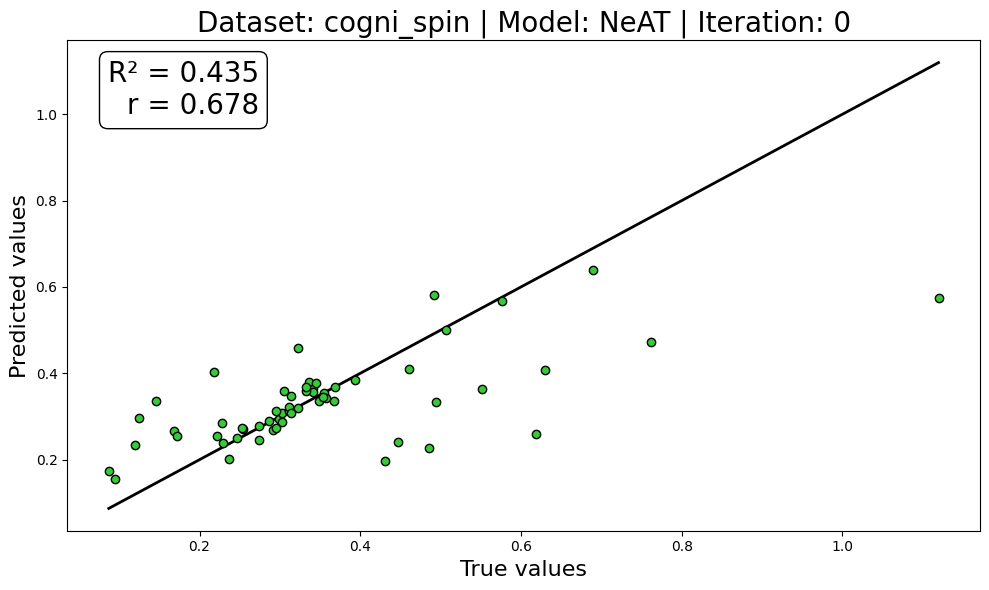

In [ ]:
parity_plot(dataset_i = 2, model_i = 3, title = True)